Use the button below to see raw code in the analysis, otherwise read ahead.

In [84]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="View raw code"></form>''')

# Update to Density Calculator

## *Completed for*: Bridger Teton Avalanche Center  

## Patrick Wright, Inversion Labs

## August 10 2017

# Contents
 <p><div class="lev1"><a href="#1.-Summary"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></div><div class="lev1"><a href="#2.-Updated-3D-plots-with-best-fit-planes"><span class="toc-item-num">2&nbsp;&nbsp;</span>Updated 3D plots with best-fit planes</a></div><div class="lev1"><a href="#3.-Updated-equation-coefficients"><span class="toc-item-num">3&nbsp;&nbsp;</span>Updated equation coefficients</a></div><div class="lev1"><a href="#4.-Updated-wall-chart-comparison"><span class="toc-item-num">4&nbsp;&nbsp;</span>Updated wall chart comparison</a></div>

# 1. Summary

An update to the BTAC Density Calculator tool was completed in early August, 2017. Previous to this update, the density calculator was missing data for the 1997-98 through 2000-01 seasons. Although air temperature and snow density data was available for this period, Summit wind data was missing from the historical database, preventing analysis for the period. Using printed records, Bob Comey manually entered temperature and wind data for these four seasons. The following document summarizes changes to the dataset, and resulting changes to the density calculator tool.

**New data: Total Wind Miles, Summit**

The following plot shows new wind data in red, and the previous existing dataset in blue. Note that the new data at the end of the record is recent data included since the last data download was completed for the density calculator (Jan. 24, 2016).

In [85]:
#!/usr/bin/env python

# Script to analyze air temp, density, and wind data
# Patrick Wright, Inversion Labs
# Job: BTAC
# January, 2016

# 'update' version: 
# Analyzing for differences in data, and producing new coefficients for the
# density calculator - following B. Comey's data update. Main change is the
# addition of Summit winds for 1997-98 thru 2000-01.
# PJW
# August, 2017

import numpy as np
import scipy as sp
from scipy import stats
import scipy.stats as stats
import pylab 
import pandas as pd
from IPython import embed
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
import datetime as dt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppressing the following warning, for purposes of retaining the legacy code:

#t_d_w-update.py:124: FutureWarning: 
#.resample() is now a deferred operation
#You called __getitem__(...) on this deferred object which materialized it into
#a series by implicitly taking the mean.  Use .resample(...).mean() instead

# --------------------------------------------------------------------------
def histoplot(data,titlestring):
	num_bins=(2060 / 10.)
	fig10 = plt.figure(figsize=(10,7))
	ax = fig10.add_subplot(111)
	n, bins, patches = plt.hist(data, num_bins, normed=1, facecolor='blue', alpha = 0.5)
	#plt.axvline(x=np.median(data), ymin=0, ymax=180, linewidth=1, color='r')
	#plt.axvline(x=np.mean(data), ymin=0, ymax=180, linewidth=1, color='k')
	ax.set_title(titlestring)
	ax.set_xlabel('density')
	ax.set_ylabel('# measurements / 10')

# --------------------------------------------------------------------------
#print "Processing datafiles..."

# Define directory paths:
fpath_1='historic_20160124.csv' # historical data
fpath_2='recent_20160124.csv' # since 2002
fpath_3='historic_20170802.csv' # historical data
fpath_4='recent_20170802.csv' # since 2002

# Read in data:
data1 = pd.read_csv(fpath_1, sep=',')
data2 = pd.read_csv(fpath_2, sep=',')
data3 = pd.read_csv(fpath_3, sep=',', low_memory=False)
data4 = pd.read_csv(fpath_4, sep=',', low_memory=False)

# Convert datetime strings to a Pandas datetime object
timestamp1 = data1['fldDate']
dt1 = pd.to_datetime(timestamp1, infer_datetime_format=True)
timestamp2 = data2['fldDate']
dt2 = pd.to_datetime(timestamp2, infer_datetime_format=True)
timestamp3 = data3['fldDate']
dt3 = pd.to_datetime(timestamp3, infer_datetime_format=True)
timestamp4 = data4['fldDate']
dt4 = pd.to_datetime(timestamp4, infer_datetime_format=True)

# set index of dataframes to datetime
data1_dt = data1.set_index(dt1)
data2_dt = data2.set_index(dt2)
data3_dt = data3.set_index(dt3)
data4_dt = data4.set_index(dt4)

# get rid of redundant date column:
data1_dt.drop('fldDate', axis=1, inplace=True)
data2_dt.drop('fldDate', axis=1, inplace=True)
data3_dt.drop('fldDate', axis=1, inplace=True)
data4_dt.drop('fldDate', axis=1, inplace=True)

# ---------------------------------------------
# WIND -- Total Miles Summit
# ---------------------------------------------
total_miles_historic_old = (data1_dt['UWind24_06Miles'] + data1_dt['UWind06_12Miles']
                        + data1_dt['UWind12_18Miles'] + data1_dt['UWind18_24Miles'])

total_miles_recent_old = data2_dt['TtlWindMilesSummit']

total_miles_historic_new = (data3_dt['UWind24_06Miles'] + data3_dt['UWind06_12Miles']
                        + data3_dt['UWind12_18Miles'] + data3_dt['UWind18_24Miles'])

total_miles_recent_new = data4_dt['TtlWindMilesSummit']

# BUILD CONTINUOUS WIND SERIES:
total_miles1_old = total_miles_historic_old[:'2002-01-30']
total_miles2_old = total_miles_recent_old
total_miles1_new = total_miles_historic_new[:'2002-01-30']
total_miles2_new = total_miles_recent_new

total_miles_list_old = [total_miles1_old, total_miles2_old]
total_miles_list_new = [total_miles1_new, total_miles2_new]

total_miles_old = pd.concat(total_miles_list_old)
total_miles_new = pd.concat(total_miles_list_new)

# Count NaNs in wind data:
NaNcount_wind_old = total_miles_old.isnull().sum()
fractNaN_wind_old = float(NaNcount_wind_old) / float(len(total_miles_old))

#print '------------------------------'
#print "%s NaN values in total_miles_old" %NaNcount_wind_old
#print "%f of data" %fractNaN_wind_old 
#print '------------------------------'

# Count NaNs in wind data:
NaNcount_wind_new = total_miles_new.isnull().sum()
fractNaN_wind_new = float(NaNcount_wind_new) / float(len(total_miles_new))

#print '------------------------------'
#print "%s NaN values in total_miles_new" %NaNcount_wind_new
#print "%f of data" %fractNaN_wind_new
#print '------------------------------'

total_miles_resample_old = total_miles_old.resample('1D')

total_miles_resample_old = total_miles_resample_old['1974-12-16':'2016-01-21'] # common to last NewSnowMid entry

total_miles_resample_new = total_miles_new.resample('1D')

total_miles_resample_new = total_miles_resample_new['1974-12-16':'2017-07-06'] # common to last NewSnowMid entry

# ---------------------------------------------
# TEMP
# ---------------------------------------------

# MID:
# Grab current/max/min from data1
CurTemp1_old = data1_dt.CurTempMid[:'2002-01-30']
MaxTemp1_old = data1_dt.MaxTempMid[:'2002-01-30']
MinTemp1_old = data1_dt.MinTempMid[:'2002-01-30']

CurTemp1_new = data3_dt.CurTempMid[:'2002-01-30']
MaxTemp1_new = data3_dt.MaxTempMid[:'2002-01-30']
MinTemp1_new = data3_dt.MinTempMid[:'2002-01-30']

# Grab current/max/min from data2
CurTemp2_old = data2_dt.CurTempMid
MaxTemp2_old = data2_dt.MaxTempMid
MinTemp2_old = data2_dt.MinTempMid

CurTemp2_new = data4_dt.CurTempMid
MaxTemp2_new = data4_dt.MaxTempMid
MinTemp2_new = data4_dt.MinTempMid

# Define two corresponding series as a list
CurTemp_data_old = [CurTemp1_old, CurTemp2_old]
MaxTemp_data_old = [MaxTemp1_old, MaxTemp2_old]
MinTemp_data_old = [MinTemp1_old, MinTemp2_old]

CurTemp_data_new = [CurTemp1_new, CurTemp2_new]
MaxTemp_data_new = [MaxTemp1_new, MaxTemp2_new]
MinTemp_data_new = [MinTemp1_new, MinTemp2_new]

# Concat to one continuous variable
CurTempMid_old = pd.concat(CurTemp_data_old)
MaxTempMid_old = pd.concat(MaxTemp_data_old)
MinTempMid_old = pd.concat(MinTemp_data_old)

CurTempMid_new = pd.concat(CurTemp_data_new)
MaxTempMid_new = pd.concat(MaxTemp_data_new)
MinTempMid_new = pd.concat(MinTemp_data_new)

## Count NaNs in temp data:
#NaNcount_Cur = CurTempMid.isnull().sum()
#fractNaN_Cur = float(NaNcount_Cur) / float(len(CurTempMid))
#NaNcount_Max = MaxTempMid.isnull().sum()
#fractNaN_Max = float(NaNcount_Max) / float(len(MaxTempMid))
#NaNcount_Min = MinTempMid.isnull().sum()
#fractNaN_Min = float(NaNcount_Min) / float(len(MinTempMid))

#print '------------------------------'
#print "%s NaN values in CurTempMid" %NaNcount_Cur
#print "%f of data" %fractNaN_Cur 
#print "%s NaN values in MaxTempMid" %NaNcount_Max
#print "%f of data" %fractNaN_Max
#print "%s NaN values in MinTempMid" %NaNcount_Min
#print "%f of data" %fractNaN_Min 
#print '------------------------------'

# RESAMPLE (runs through summers)
CurTempMid_resample_old = CurTempMid_old.resample('1D')
MaxTempMid_resample_old = MaxTempMid_old.resample('1D')
MinTempMid_resample_old = MinTempMid_old.resample('1D')

CurTempMid_resample_new = CurTempMid_new.resample('1D')
MaxTempMid_resample_new = MaxTempMid_new.resample('1D')
MinTempMid_resample_new = MinTempMid_new.resample('1D')

CurTempMid_resample_old = CurTempMid_resample_old['1974-12-16':'2016-01-21']
MaxTempMid_resample_old = MaxTempMid_resample_old['1974-12-16':'2016-01-21']
MinTempMid_resample_old = MinTempMid_resample_old['1974-12-16':'2016-01-21']
MinTempMid_resample_old[MinTempMid_resample_old < -50.] = np.NaN

CurTempMid_resample_new = CurTempMid_resample_new['1974-12-16':'2017-07-06']
MaxTempMid_resample_new = MaxTempMid_resample_new['1974-12-16':'2017-07-06']
MinTempMid_resample_new = MinTempMid_resample_new['1974-12-16':'2017-07-06']
MinTempMid_resample_new[MinTempMid_resample_new < -50.] = np.NaN

# Calc average temp:
temp_mean_mid_old = (MaxTempMid_resample_old + MinTempMid_resample_old) / 2.

temp_mean_mid_new = (MaxTempMid_resample_new + MinTempMid_resample_new) / 2.

#---------------------------------------------------------------------

# RAYMER:
# Grab current/max/min from data1
CurTemp1_old = data1_dt.CurTempRay[:'2002-01-30']
MaxTemp1_old = data1_dt.MaxTempRay[:'2002-01-30']
MinTemp1_old = data1_dt.MinTempRay[:'2002-01-30']

CurTemp1_new = data3_dt.CurTempRay[:'2002-01-30']
MaxTemp1_new = data3_dt.MaxTempRay[:'2002-01-30']
MinTemp1_new = data3_dt.MinTempRay[:'2002-01-30']

# Grab current/max/min from data2
CurTemp2_old = data2_dt.CurTempRay
MaxTemp2_old = data2_dt.MaxTempRay
MinTemp2_old = data2_dt.MinTempRay

CurTemp2_new = data4_dt.CurTempRay
MaxTemp2_new = data4_dt.MaxTempRay
MinTemp2_new = data4_dt.MinTempRay

# Define two corresponding series as a list
CurTemp_data_old = [CurTemp1_old, CurTemp2_old]
MaxTemp_data_old = [MaxTemp1_old, MaxTemp2_old]
MinTemp_data_old = [MinTemp1_old, MinTemp2_old]

CurTemp_data_new = [CurTemp1_new, CurTemp2_new]
MaxTemp_data_new = [MaxTemp1_new, MaxTemp2_new]
MinTemp_data_new = [MinTemp1_new, MinTemp2_new]

# Concat to one continuous variable
CurTempRay_old = pd.concat(CurTemp_data_old)
MaxTempRay_old = pd.concat(MaxTemp_data_old)
MinTempRay_old = pd.concat(MinTemp_data_old)

CurTempRay_new = pd.concat(CurTemp_data_new)
MaxTempRay_new = pd.concat(MaxTemp_data_new)
MinTempRay_new = pd.concat(MinTemp_data_new)

# Count NaNs in temp data:
#NaNcount_Cur = CurTempRay.isnull().sum()
#fractNaN_Cur = float(NaNcount_Cur) / float(len(CurTempRay))
#NaNcount_Max = MaxTempRay.isnull().sum()
#fractNaN_Max = float(NaNcount_Max) / float(len(MaxTempRay))
#NaNcount_Min = MinTempRay.isnull().sum()
#fractNaN_Min = float(NaNcount_Min) / float(len(MinTempRay))

#print '------------------------------'
#print "%s NaN values in CurTempRay" %NaNcount_Cur
#print "%f of data" %fractNaN_Cur 
#print "%s NaN values in MaxTempRay" %NaNcount_Max
#print "%f of data" %fractNaN_Max
#print "%s NaN values in MinTempRay" %NaNcount_Min
#print "%f of data" %fractNaN_Min 
#print '------------------------------'

# RESAMPLE (runs through summers)
CurTempRay_resample_old = CurTempRay_old.resample('1D')
MaxTempRay_resample_old = MaxTempRay_old.resample('1D')
MinTempRay_resample_old = MinTempRay_old.resample('1D')

CurTempRay_resample_new = CurTempRay_new.resample('1D')
MaxTempRay_resample_new = MaxTempRay_new.resample('1D')
MinTempRay_resample_new = MinTempRay_new.resample('1D')

CurTempRay_resample_old = CurTempRay_resample_old['1974-12-16':'2016-01-21']
CurTempRay_resample_new = CurTempRay_resample_new['1974-12-16':'2017-07-06']

MaxTempRay_resample_old = MaxTempRay_resample_old['1974-12-16':'2016-01-21']
MaxTempRay_resample_old[MaxTempRay_resample_old < -50.] = np.NaN
MaxTempRay_resample_old[MaxTempRay_resample_old > 100.] = np.NaN

MaxTempRay_resample_new = MaxTempRay_resample_new['1974-12-16':'2017-07-06']
MaxTempRay_resample_new[MaxTempRay_resample_new < -50.] = np.NaN
MaxTempRay_resample_new[MaxTempRay_resample_new > 100.] = np.NaN

MinTempRay_resample_old = MinTempRay_resample_old['1974-12-16':'2016-01-21']
MinTempRay_resample_old[MinTempRay_resample_old < -50.] = np.NaN

MinTempRay_resample_new = MinTempRay_resample_new['1974-12-16':'2017-07-06']
MinTempRay_resample_new[MinTempRay_resample_new < -50.] = np.NaN

#embed()
# Calc average temp:
temp_mean_ray_old = (MaxTempRay_resample_old + MinTempRay_resample_old) / 2.
temp_mean_ray_new = (MaxTempRay_resample_new + MinTempRay_resample_new) / 2.

#---------------------------------------------------------------------

# SUMMIT:
# Grab current/max/min from data1
CurTemp1_old = data1_dt.CurTempSummit[:'2002-01-30']
MaxTemp1_old = data1_dt.MaxTempSummit[:'2002-01-30']
MinTemp1_old = data1_dt.MinTempSummit[:'2002-01-30']

CurTemp1_new = data3_dt.CurTempSummit[:'2002-01-30']
MaxTemp1_new = data3_dt.MaxTempSummit[:'2002-01-30']
MinTemp1_new = data3_dt.MinTempSummit[:'2002-01-30']

# Grab current/max/min from data2
CurTemp2_old = data2_dt.CurTempSummit
MaxTemp2_old = data2_dt.MaxTempSummit
MinTemp2_old = data2_dt.MinTempSummit

CurTemp2_new = data4_dt.CurTempSummit
MaxTemp2_new = data4_dt.MaxTempSummit
MinTemp2_new = data4_dt.MinTempSummit

# Define two corresponding series as a list
CurTemp_data_old = [CurTemp1_old, CurTemp2_old]
MaxTemp_data_old = [MaxTemp1_old, MaxTemp2_old]
MinTemp_data_old = [MinTemp1_old, MinTemp2_old]

CurTemp_data_new = [CurTemp1_new, CurTemp2_new]
MaxTemp_data_new = [MaxTemp1_new, MaxTemp2_new]
MinTemp_data_new = [MinTemp1_new, MinTemp2_new]

# Concat to one continuous variable
CurTempSummit_old = pd.concat(CurTemp_data_old)
MaxTempSummit_old = pd.concat(MaxTemp_data_old)
MinTempSummit_old = pd.concat(MinTemp_data_old)

CurTempSummit_new = pd.concat(CurTemp_data_new)
MaxTempSummit_new = pd.concat(MaxTemp_data_new)
MinTempSummit_new = pd.concat(MinTemp_data_new)

## Count NaNs in temp data:
#NaNcount_Cur = CurTempSummit.isnull().sum()
#fractNaN_Cur = float(NaNcount_Cur) / float(len(CurTempSummit))
#NaNcount_Max = MaxTempSummit.isnull().sum()
#fractNaN_Max = float(NaNcount_Max) / float(len(MaxTempSummit))
#NaNcount_Min = MinTempSummit.isnull().sum()
#fractNaN_Min = float(NaNcount_Min) / float(len(MinTempSummit))

#print '------------------------------'
#print "%s NaN values in CurTempSummit" %NaNcount_Cur
#print "%f of data" %fractNaN_Cur 
#print "%s NaN values in MaxTempSummit" %NaNcount_Max
#print "%f of data" %fractNaN_Max
#print "%s NaN values in MinTempSummit" %NaNcount_Min
#print "%f of data" %fractNaN_Min 
#print '------------------------------'

# RESAMPLE (runs through summers)
CurTempSummit_resample_old = CurTempSummit_old.resample('1D')
MaxTempSummit_resample_old = MaxTempSummit_old.resample('1D')
MinTempSummit_resample_old = MinTempSummit_old.resample('1D')

CurTempSummit_resample_new = CurTempSummit_new.resample('1D')
MaxTempSummit_resample_new = MaxTempSummit_new.resample('1D')
MinTempSummit_resample_new = MinTempSummit_new.resample('1D')

CurTempSummit_resample_old = CurTempSummit_resample_old['1974-12-16':'2016-01-21']
MaxTempSummit_resample_old = MaxTempSummit_resample_old['1974-12-16':'2016-01-21']
MaxTempSummit_resample_old[MaxTempSummit_resample_old < -50.] = np.NaN
MaxTempSummit_resample_old[MaxTempSummit_resample_old > 100.] = np.NaN

CurTempSummit_resample_new = CurTempSummit_resample_new['1974-12-16':'2017-07-06']
MaxTempSummit_resample_new = MaxTempSummit_resample_new['1974-12-16':'2017-07-06']
MaxTempSummit_resample_new[MaxTempSummit_resample_new < -50.] = np.NaN
MaxTempSummit_resample_new[MaxTempSummit_resample_new > 100.] = np.NaN

MinTempSummit_resample_old = MinTempSummit_resample_old['1974-12-16':'2016-01-21']
MinTempSummit_resample_old[MinTempSummit_resample_old < -50.] = np.NaN

MinTempSummit_resample_new = MinTempSummit_resample_new['1974-12-16':'2017-07-06']
MinTempSummit_resample_new[MinTempSummit_resample_new < -50.] = np.NaN


# Calc average temp:
temp_mean_Summit_old = (MaxTempSummit_resample_old + MinTempSummit_resample_old) / 2.
temp_mean_Summit_new = (MaxTempSummit_resample_new + MinTempSummit_resample_new) / 2.

#embed()

# ---------------------------------------------
# SNOW
# ---------------------------------------------

# MID
# Count initial NaNs in snow data:
#NaNcount_newsnow = data1_dt.NewSnowMid.isnull().sum()
#fractNaN_newsnow = float(NaNcount_newsnow) / float(len(data1_dt.NewSnowMid))
#NaNcount_SWE = data1_dt.SWEMid.isnull().sum()
#fractNaN_SWE = float(NaNcount_SWE) / float(len(data1_dt.SWEMid))

#print '------------------------------'
#print "%s NaN values in NewSnowMid" %NaNcount_newsnow
#print "%f of data" %fractNaN_newsnow 
#print "%s NaN values in SWEMid" %NaNcount_SWE
#print "%f of data" %fractNaN_SWE
#print '------------------------------'

#print 'Dropping any new snow entries <=1"'

NewSnowMid_countzero_old = data1_dt.NewSnowMid[data1_dt.NewSnowMid == 0.0]
NewSnowMid_drop_old = data1_dt.NewSnowMid[data1_dt.NewSnowMid > 1.0]

NewSnowMid_countzero_new = data3_dt.NewSnowMid[data3_dt.NewSnowMid == 0.0]
NewSnowMid_drop_new = data3_dt.NewSnowMid[data3_dt.NewSnowMid > 1.0]

lessthaninch_old = len(data1_dt.NewSnowMid) - len(NewSnowMid_drop_old) - len(NewSnowMid_countzero_old)
totaldrop_old = len(data1_dt.NewSnowMid) - len(NewSnowMid_drop_old)

lessthaninch_new = len(data3_dt.NewSnowMid) - len(NewSnowMid_drop_new) - len(NewSnowMid_countzero_new)
totaldrop_new = len(data3_dt.NewSnowMid) - len(NewSnowMid_drop_new)

#print "%s entries in NewSnowMid, >0 <=1 (OLD)" %lessthaninch_old
#print "dropped %s entries from NewSnowMid (including 0) (OLD)" %totaldrop_old

#print "%s entries in NewSnowMid, >0 <=1 (NEW)" %lessthaninch_new
#print "dropped %s entries from NewSnowMid (including 0) (NEW)" %totaldrop_new

# Match length with temp data
NewSnowMid_resample_old = NewSnowMid_drop_old.resample('1D')
SWEMid_resample_old = data1_dt.SWEMid.resample('1D')

NewSnowMid_resample_new = NewSnowMid_drop_new.resample('1D')
SWEMid_resample_new = data3_dt.SWEMid.resample('1D')

NewSnowMid_resample_old = NewSnowMid_resample_old['1974-12-16':'2016-01-21']
SWEMid_resample_old = SWEMid_resample_old['1974-12-16':'2016-01-21']

NewSnowMid_resample_new = NewSnowMid_resample_new['1974-12-16':'2017-07-06']
SWEMid_resample_new = SWEMid_resample_new['1974-12-16':'2017-07-06']

densityMid_old = SWEMid_resample_old / NewSnowMid_resample_old 
densityMid_new = SWEMid_resample_new / NewSnowMid_resample_new
# any NaNs in NewSnowMid_resample should set corresponding densityMid to NaN

#print 'Dropping outlier high density records'
densityMid_old = densityMid_old[densityMid_old < 0.25]
densityMid_new = densityMid_new[densityMid_new < 0.25]

#------------------------------------------------------------------------------

# BOWL:
# Count initial NaNs in snow data:
#NaNcount_newsnow = data1_dt.NewSnowBowl.isnull().sum()
#fractNaN_newsnow = float(NaNcount_newsnow) / float(len(data1_dt.NewSnowBowl))
#NaNcount_SWE = data1_dt.SWEBowl.isnull().sum()
#fractNaN_SWE = float(NaNcount_SWE) / float(len(data1_dt.SWEBowl))

#print '------------------------------'
#print "%s NaN values in NewSnowBowl" %NaNcount_newsnow
#print "%f of data" %fractNaN_newsnow 
#print "%s NaN values in SWEBowl" %NaNcount_SWE
#print "%f of data" %fractNaN_SWE
#print '------------------------------'

#print 'Dropping any new snow entries <=1"'

NewSnowBowl_countzero_old = data1_dt.NewSnowBowl[data1_dt.NewSnowBowl == 0.0]
NewSnowBowl_drop_old = data1_dt.NewSnowBowl[data1_dt.NewSnowBowl > 1.0]

NewSnowBowl_countzero_new = data3_dt.NewSnowBowl[data3_dt.NewSnowBowl == 0.0]
NewSnowBowl_drop_new = data3_dt.NewSnowBowl[data3_dt.NewSnowBowl > 1.0]

lessthaninch_old = len(data1_dt.NewSnowBowl) - len(NewSnowBowl_drop_old) - len(NewSnowBowl_countzero_old)
totaldrop_old = len(data1_dt.NewSnowBowl) - len(NewSnowBowl_drop_old)

lessthaninch_new = len(data3_dt.NewSnowBowl) - len(NewSnowBowl_drop_new) - len(NewSnowBowl_countzero_new)
totaldrop_new = len(data3_dt.NewSnowBowl) - len(NewSnowBowl_drop_new)

#print "%s entries in NewSnowBowl, >0 <=1 (OLD)" %lessthaninch_old
#print "dropped %s entries from NewSnowBowl (including 0) (OLD)" %totaldrop_old

#print "%s entries in NewSnowBowl, >0 <=1 (NEW)" %lessthaninch_new
#print "dropped %s entries from NewSnowBowl (including 0) (NEW)" %totaldrop_new

# Match length with temp data
NewSnowBowl_resample_old = NewSnowBowl_drop_old.resample('1D')
SWEBowl_resample_old = data1_dt.SWEBowl.resample('1D')

NewSnowBowl_resample_new = NewSnowBowl_drop_new.resample('1D')
SWEBowl_resample_new = data3_dt.SWEBowl.resample('1D')

NewSnowBowl_resample_old = NewSnowBowl_resample_old['1974-12-16':'2016-01-21']
SWEBowl_resample_old = SWEBowl_resample_old['1974-12-16':'2016-01-21']

NewSnowBowl_resample_new = NewSnowBowl_resample_new['1974-12-16':'2017-07-06']
SWEBowl_resample_new = SWEBowl_resample_new['1974-12-16':'2017-07-06']

densityBowl_old = SWEBowl_resample_old / NewSnowBowl_resample_old 
densityBowl_new = SWEBowl_resample_new / NewSnowBowl_resample_new 
# any NaNs in NewSnowBowl_resample should set corresponding densityMid to NaN

#print 'Dropping outlier high density records'
densityBowl_old = densityBowl_old[densityBowl_old < 0.25]
densityBowl_new = densityBowl_new[densityBowl_new < 0.25]

#------------------------------------------------------------------------------

# BRIDGER:
# Count initial NaNs in snow data:
#NaNcount_newsnow = data1_dt.NewSnowBridger.isnull().sum()
#fractNaN_newsnow = float(NaNcount_newsnow) / float(len(data1_dt.NewSnowBridger))
#NaNcount_SWE = data1_dt.SWEBridger.isnull().sum()
#fractNaN_SWE = float(NaNcount_SWE) / float(len(data1_dt.SWEBridger))

#print '------------------------------'
#print "%s NaN values in NewSnowBridger" %NaNcount_newsnow
#print "%f of data" %fractNaN_newsnow 
#print "%s NaN values in SWEBridger" %NaNcount_SWE
#print "%f of data" %fractNaN_SWE
#print '------------------------------'

#print 'Dropping any new snow entries <=1"'

NewSnowBridger_countzero_old = data1_dt.NewSnowBridger[data1_dt.NewSnowBridger == 0.0]
NewSnowBridger_drop_old = data1_dt.NewSnowBridger[data1_dt.NewSnowBridger > 1.0]

NewSnowBridger_countzero_new = data3_dt.NewSnowBridger[data3_dt.NewSnowBridger == 0.0]
NewSnowBridger_drop_new = data3_dt.NewSnowBridger[data3_dt.NewSnowBridger > 1.0]

lessthaninch_old = len(data1_dt.NewSnowBridger) - len(NewSnowBridger_drop_old) - len(NewSnowBridger_countzero_old)
totaldrop_old = len(data1_dt.NewSnowBridger) - len(NewSnowBridger_drop_old)

lessthaninch_new = len(data3_dt.NewSnowBridger) - len(NewSnowBridger_drop_new) - len(NewSnowBridger_countzero_new)
totaldrop_new = len(data3_dt.NewSnowBridger) - len(NewSnowBridger_drop_new)

#print "%s entries in NewSnowBridger, >0 <=1 (OLD)" %lessthaninch_old
#print "dropped %s entries from NewSnowBridger (including 0) (OLD)" %totaldrop_old

#print "%s entries in NewSnowBridger, >0 <=1 (NEW)" %lessthaninch_new
#print "dropped %s entries from NewSnowBridger (including 0) (NEW)" %totaldrop_new

# Match length with temp data
NewSnowBridger_resample_old = NewSnowBridger_drop_old.resample('1D')
SWEBridger_resample_old = data1_dt.SWEBridger.resample('1D')

NewSnowBridger_resample_new = NewSnowBridger_drop_new.resample('1D')
SWEBridger_resample_new = data3_dt.SWEBridger.resample('1D')

NewSnowBridger_resample_old = NewSnowBridger_resample_old['1974-12-16':'2016-01-21']
SWEBridger_resample_old = SWEBridger_resample_old['1974-12-16':'2016-01-21']

NewSnowBridger_resample_new = NewSnowBridger_resample_new['1974-12-16':'2017-07-06']
SWEBridger_resample_new = SWEBridger_resample_new['1974-12-16':'2017-07-06']

densityBridger_old = SWEBridger_resample_old / NewSnowBridger_resample_old 
densityBridger_new = SWEBridger_resample_new / NewSnowBridger_resample_new 
# any NaNs in NewSnowBridger_resample should set corresponding densityMid to NaN

#print 'Dropping outlier high density records'
densityBridger_old = densityBridger_old[densityBridger_old < 0.25]
densityBridger_new = densityBridger_new[densityBridger_new < 0.25]

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

# Only select values for common integers (non-NaN):
idx_mean_mid_old = np.isfinite(temp_mean_mid_old) & np.isfinite(densityMid_old) & np.isfinite(total_miles_resample_old)

idx_mean_bowl_old = np.isfinite(temp_mean_Summit_old) & np.isfinite(densityBowl_old) & np.isfinite(total_miles_resample_old)

idx_mean_bridger_old = np.isfinite(temp_mean_ray_old) & np.isfinite(densityBridger_old) & np.isfinite(total_miles_resample_old)


idx_mean_mid_new = np.isfinite(temp_mean_mid_new) & np.isfinite(densityMid_new) & np.isfinite(total_miles_resample_new)

idx_mean_bowl_new = np.isfinite(temp_mean_Summit_new) & np.isfinite(densityBowl_new) & np.isfinite(total_miles_resample_new)

idx_mean_bridger_new = np.isfinite(temp_mean_ray_new) & np.isfinite(densityBridger_new) & np.isfinite(total_miles_resample_new)

#idx_mean_mid = idx_mean_mid[idx_mean_mid==True]
#idx_mean_bowl = idx_mean_bowl[idx_mean_bowl==True]
#idx_mean_bridger = idx_mean_bridger[idx_mean_bridger==True]

# Limit dates to Dec. 15 - March 30:
idx_mean_mid_tight_old = idx_mean_mid_old[((idx_mean_mid_old.index.month == 12) & (15 <= idx_mean_mid_old.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid_old.index.month == 1) 
              | (idx_mean_mid_old.index.month == 2) 
              | (idx_mean_mid_old.index.month == 3) & (idx_mean_mid_old.index.day <= 30 ))]  # March before the 30th inclusive 

idx_mean_bowl_tight_old = idx_mean_bowl_old[((idx_mean_bowl_old.index.month == 12) & (15 <= idx_mean_bowl_old.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid_old.index.month == 1) 
              | (idx_mean_mid_old.index.month == 2) 
              | (idx_mean_bowl_old.index.month == 3) & (idx_mean_bowl_old.index.day <= 30 ))]  # March before the 30th inclusive 

idx_mean_bridger_tight_old = idx_mean_bridger_old[((idx_mean_bridger_old.index.month == 12) & (15 <= idx_mean_bridger_old.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid_old.index.month == 1) 
              | (idx_mean_mid_old.index.month == 2) 
              | (idx_mean_bridger_old.index.month == 3) & (idx_mean_bridger_old.index.day <= 30 ))]  # March before the 30th inclusive 


idx_mean_mid_tight_new = idx_mean_mid_new[((idx_mean_mid_new.index.month == 12) & (15 <= idx_mean_mid_new.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid_new.index.month == 1) 
              | (idx_mean_mid_new.index.month == 2) 
              | (idx_mean_mid_new.index.month == 3) & (idx_mean_mid_new.index.day <= 30 ))]  # March before the 30th inclusive 

idx_mean_bowl_tight_new = idx_mean_bowl_new[((idx_mean_bowl_new.index.month == 12) & (15 <= idx_mean_bowl_new.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid_new.index.month == 1) 
              | (idx_mean_mid_new.index.month == 2) 
              | (idx_mean_bowl_new.index.month == 3) & (idx_mean_bowl_new.index.day <= 30 ))]  # March before the 30th inclusive 

idx_mean_bridger_tight_new = idx_mean_bridger_new[((idx_mean_bridger_new.index.month == 12) & (15 <= idx_mean_bridger_new.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid_new.index.month == 1) 
              | (idx_mean_mid_new.index.month == 2) 
              | (idx_mean_bridger_new.index.month == 3) & (idx_mean_bridger_new.index.day <= 30 ))]  # March before the 30th inclusive

idx_mid_old = idx_mean_mid_tight_old[idx_mean_mid_tight_old==True]
idx_bowl_old = idx_mean_bowl_tight_old[idx_mean_bowl_tight_old==True]
idx_bridger_old = idx_mean_bridger_tight_old[idx_mean_bridger_tight_old==True]

idx_mid_new = idx_mean_mid_tight_new[idx_mean_mid_tight_new==True]
idx_bowl_new = idx_mean_bowl_tight_new[idx_mean_bowl_tight_new==True]
idx_bridger_new = idx_mean_bridger_tight_new[idx_mean_bridger_tight_new==True]

In [86]:
%matplotlib inline

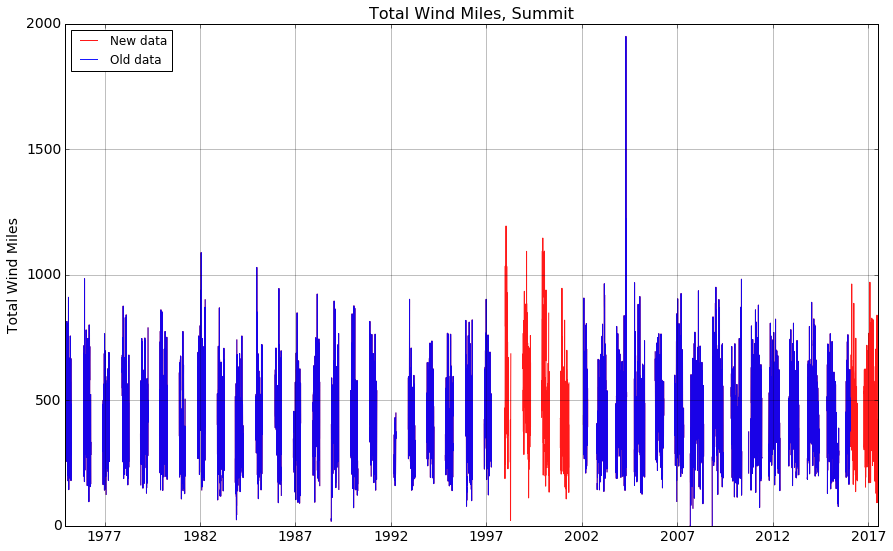

In [87]:
plt.figure(figsize=(9 * 1.618, 9))
plt.plot(total_miles_resample_new.index, total_miles_resample_new, color='r', alpha=0.9, label='New data')
plt.plot(total_miles_resample_old.index, total_miles_resample_old, color='b', alpha=0.9, label='Old data')
plt.ylabel('Total Wind Miles', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Total Wind Miles, Summit', fontsize=16)
#plt.ylim((0, 0))
plt.grid(which='major', color='k', alpha=0.5, linestyle='-')

plt.legend(loc=2)

plt.show()

**New data: Air Temperature**

The only significant amount of new air temperature data added was for Summit (Upper). The 1999-2000 and 2000-01 seasons were added to the record for this location. Note that the density calculator uses 24-hr mean air temperature (calculated from 24-hr min and max temps). New data for Summit (Upper) 24-hr mean air temperature is shown below:

**Changes to Summit temperature data:**

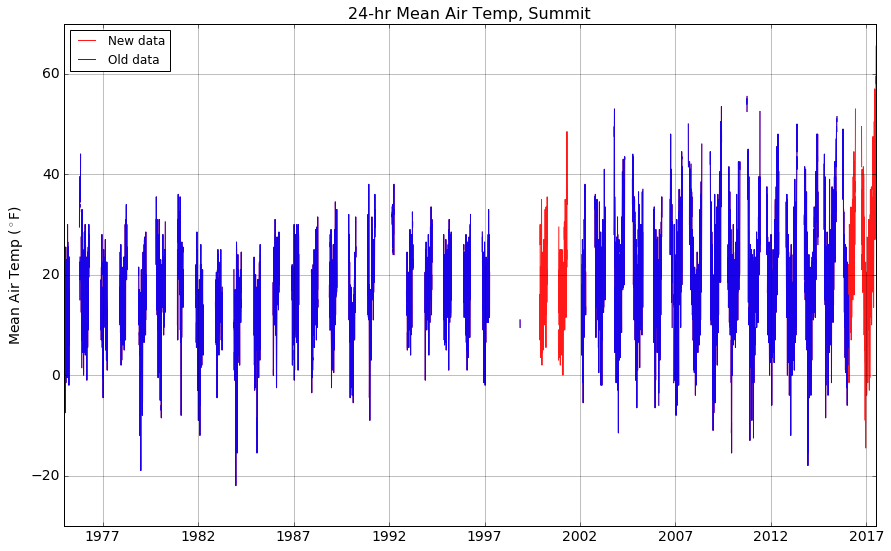

In [88]:
plt.figure(figsize=(9 * 1.618, 9))
plt.plot(temp_mean_Summit_new.index, temp_mean_Summit_new, color='r', alpha=0.9, label='New data')
plt.plot(temp_mean_Summit_old.index, temp_mean_Summit_old, color='b', alpha=0.9, label='Old data')
plt.ylabel('Mean Air Temp ($^\circ$F)', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('24-hr Mean Air Temp, Summit', fontsize=16)
#plt.ylim((0, 0))
plt.grid(which='major', color='k', alpha=0.5, linestyle='-')

plt.legend(loc=2)

**Changes to Mid Mountain and Raymer temperature data:**

Although air temperature records for the Mid Mountain Plot and Raymer Plot previously existed for the 1997-98 through 2001-02 seaons, there were minor changes to the data for these locations. Over this period, short missing gaps in temperature records were filled and additional data was added to end of each season (during April). In addition, a limited number of records were changed from the previous dataset (shown with occasional differences in the blue and red lines below). I did not complete analysis at this time to investigate if changes to the 24-hr mean air temp data is sourced in changes to 24-hr minimums or 24-hr maximums. The following plot is an example of changes to the temperature data, shown for the 1998-99 season at the Mid Mountain plot. Data for other seasons between 1997-2002, at both Mid Mountain and the Raymer Plot, show similar patterns between old and new data:

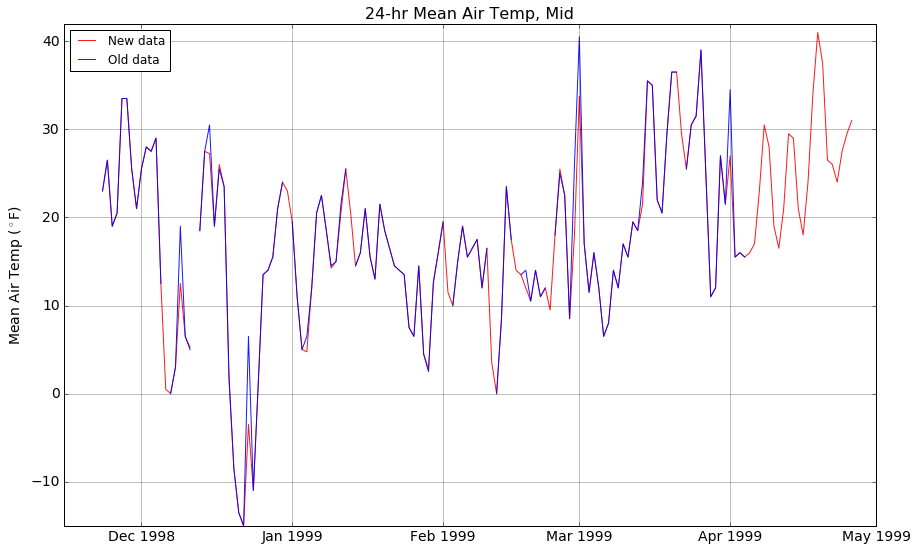

In [89]:
plt.figure(figsize=(9 * 1.618, 9))
plt.plot(temp_mean_mid_new.index, temp_mean_mid_new, color='r', alpha=0.9, label='New data')
plt.plot(temp_mean_mid_old.index, temp_mean_mid_old, color='b', alpha=0.9, label='Old data')
plt.ylabel('Mean Air Temp ($^\circ$F)', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('24-hr Mean Air Temp, Mid', fontsize=16)
plt.ylim((-15, 42))
plt.xlim(('1998-11-15', '1999-05-01'))
plt.grid(which='major', color='k', alpha=0.5, linestyle='-')

plt.legend(loc=2)

**Snow density data** remained unchanged from the old dataset.

# 2. Updated 3D plots with best-fit planes

The data used for each station remains the same as previous analyses:
    
**Mid Mtn:**
* Mid Mtn previous 24-hr mean air temp
* Summit previous 24-hr total wind miles
* Mid Mtn new snow density

**Rendezvous Bowl:**
* Summit ('Upper') previous 24-hr mean air temp

*Note: Ideally, Rend Bowl temps should replace recent data for Summit temps.*
* Summit previous 24-hr total wind miles
* Rendezvous Bowl new snow density

**Raymer (Bridger):**
* Raymer previous 24-hr mean air temp
* Summit previous 24-hr total wind miles
* Raymer new snow density

New snow totals of 1" or less were not included in density calculations, and the data was constrained to December 15 - March 30.

**Increase in total data points with new data:**

In [90]:
print ''
print 'OLD:'
print '-----------------------'
print '|  MID: n = %d      |' % len(idx_mid_old[idx_mid_old==True])
print '|  BOWL: n = %d     |' % len(idx_bowl_old[idx_bowl_old==True])
print '|  BRIDGER: n = %d   |' % len(idx_bridger_old[idx_bridger_old==True])
print '-----------------------'
print ''

print ''
print 'NEW:'
print '-----------------------'
print '|  MID: n = %d      |' % len(idx_mid_new[idx_mid_new==True])
print '|  BOWL: n = %d     |' % len(idx_bowl_new[idx_bowl_new==True])
print '|  BRIDGER: n = %d   |' % len(idx_bridger_new[idx_bridger_new==True])
print '-----------------------'
print ''


OLD:
-----------------------
|  MID: n = 1583      |
|  BOWL: n = 1658     |
|  BRIDGER: n = 672   |
-----------------------


NEW:
-----------------------
|  MID: n = 1832      |
|  BOWL: n = 1838     |
|  BRIDGER: n = 950   |
-----------------------



* Mid Mtn: added 249 points
* Rendezvous Bowl: added 180 points
* Bridger (Raymer): added 278 points

**Updates to best-fit solutions:**

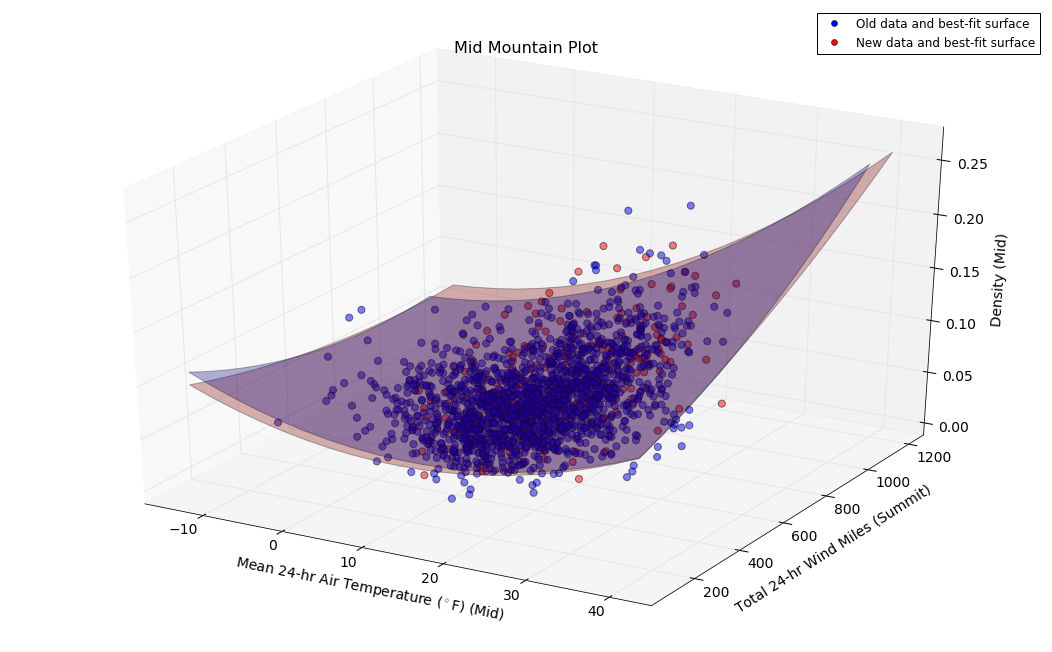

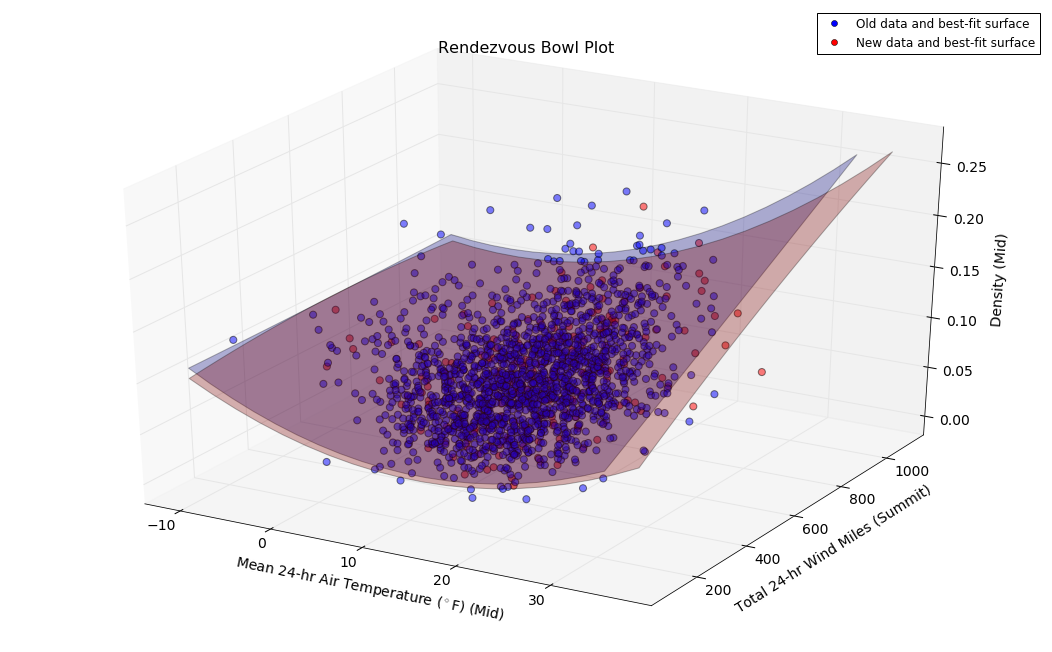

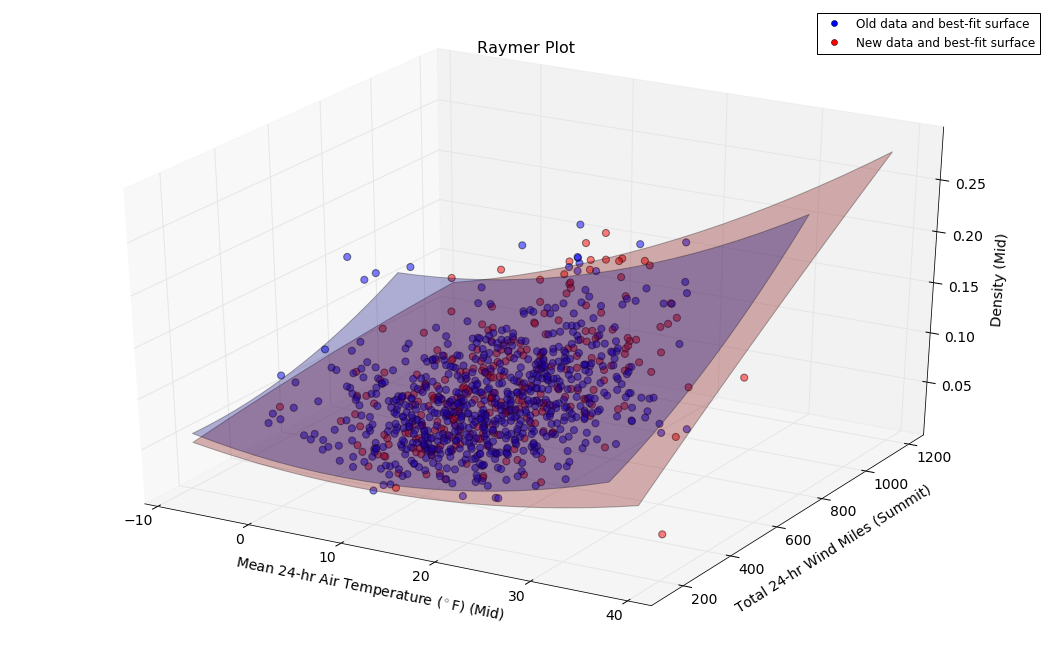

In [91]:
#--------------------------------------------------------------------------------------
# 3D PLOTS
#--------------------------------------------------------------------------------------

from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg
from matplotlib import cm

def compare_bestfitsurf(temp_old, temp_new, wind_old, wind_new, dens_old,
                        dens_new, index_old, index_new, Titlestring, printstring):
  x_old = temp_old[index_old]
  x_new = temp_new[index_new]
  #x = (x - 32.) * (5./9.)

  y_old = wind_old[index_old]
  y_new = wind_new[index_new]
  #y = y * 1.60934

  z_old = dens_old[index_old]
  z_new = dens_new[index_new]

  #--------------------------------------------------------------------------------------
  # Calc for OLD data:

  d_old = {'temp': x_old, 'wind': y_old, 'dens': z_old}
  df_old = pd.DataFrame(data=d_old)

  x_old = df_old.temp
  y_old = df_old.wind
  z_old = df_old.dens

  # Add best-fit 2D plane:

  data_old = np.c_[x_old,y_old,z_old]

  # regular grid covering the domain of the data
  mn = np.min(data_old, axis=0)
  mx = np.max(data_old, axis=0)
  X_old,Y_old = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
  XX_old = X_old.flatten()
  YY_old = Y_old.flatten()

  order = 2    # 1: linear, 2: quadratic
  if order == 1:
      # best-fit linear plane
      A_old = np.c_[data_old[:,0], data_old[:,1], np.ones(data_old.shape[0])]
      C_old,_,_,_ = scipy.linalg.lstsq(A_old, data_old[:,2])    # coefficients
      
      # evaluate it on grid
      Z_old = C_old[0]*X_old + C_old[1]*Y_old + C_old[2]
      
      # or expressed using matrix/vector product
      #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

  elif order == 2:
      # best-fit quadratic curve
      A_old = np.c_[np.ones(data_old.shape[0]), data_old[:,:2], np.prod(data_old[:,:2], axis=1), data_old[:,:2]**2]
      C_old,_,_,_ = scipy.linalg.lstsq(A_old, data_old[:,2])
      
      # evaluate it on a grid
      Z_old = np.dot(np.c_[np.ones(XX_old.shape), XX_old, YY_old, XX_old*YY_old, XX_old**2, YY_old**2], C_old).reshape(X_old.shape)


  # use this to manual calculate individual density values:
  def calc_dens_2(temp,wind):
    density = C[4]*temp**2. + C[5]*wind**2. + C[3]*temp*wind + C[1]*temp + C[2]*wind + C[0]
    return density

  #density_2 = calc_dens_2(35,1000)

  #--------------------------------------------------------------------------------------
  # Calc for NEW data:

  d_new = {'temp': x_new, 'wind': y_new, 'dens': z_new}
  df_new = pd.DataFrame(data=d_new)

  x_new = df_new.temp
  y_new = df_new.wind
  z_new = df_new.dens

  # Add best-fit 2D plane:

  data_new = np.c_[x_new,y_new,z_new]

  # regular grid covering the domain of the data
  mn = np.min(data_new, axis=0)
  mx = np.max(data_new, axis=0)
  X_new,Y_new = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
  XX_new = X_new.flatten()
  YY_new = Y_new.flatten()

  order = 2    # 1: linear, 2: quadratic
  if order == 1:
      # best-fit linear plane
      A_new = np.c_[data_new[:,0], data_new[:,1], np.ones(data_new.shape[0])]
      C_new,_,_,_ = scipy.linalg.lstsq(A_new, data_new[:,2])    # coefficients
      
      # evaluate it on grid
      Z_new = C_new[0]*X_new + C_new[1]*Y_new + C_new[2]
      
      # or expressed using matrix/vector product
      #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

  elif order == 2:
      # best-fit quadratic curve
      A_new = np.c_[np.ones(data_new.shape[0]), data_new[:,:2], np.prod(data_new[:,:2], axis=1), data_new[:,:2]**2]
      C_new,_,_,_ = scipy.linalg.lstsq(A_new, data_new[:,2])
      
      # evaluate it on a grid
      Z_new = np.dot(np.c_[np.ones(XX_new.shape), XX_new, YY_new, XX_new*YY_new, XX_new**2, YY_new**2], C_new).reshape(X_new.shape)

  #density_2 = calc_dens_2(35,1000)

  #--------------------------------------------------------------------------------------
  # Plot points and fitted surface for new and old data:
  
  # Get a dataframe of points from df_new that have unique datetime index
  # from df_old. These are used to show new points in the plots. Purely for the visual.
  # The best fit planes and coefficient values use the full dataframes for
  # old and new data, respectively.
  
  diff = df_new.index.difference(df_old.index)
  diff_new = df_new.ix[diff]
  x_diff = diff_new.temp
  y_diff = diff_new.wind
  z_diff = diff_new.dens
  diff_new = np.c_[x_diff,y_diff,z_diff]

  fig = plt.figure(figsize=(9*1.618,9))
  ax = fig.gca(projection='3d')

  surf_old = ax.plot_surface(X_old, Y_old, Z_old, rstride=50, cstride=50, color='blue', alpha=0.3)
  surf_new = ax.plot_surface(X_new, Y_new, Z_new, rstride=50, cstride=50, color='red', alpha=0.3)
  ax.scatter(data_old[:,0], data_old[:,1], data_old[:,2], c='b', s=50, alpha=0.5)
  #ax.scatter(data_new[:,0], data_new[:,1], data_new[:,2], c='r', s=50, alpha=0.5)
  ax.scatter(diff_new[:,0], diff_new[:,1], diff_new[:,2], c='r', s=50, alpha=0.5)
  
  # Dummy plotting to get a legend with single points:
  scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
  scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
  ax.legend([scatter1_proxy, scatter2_proxy], ['Old data and best-fit surface', 'New data and best-fit surface'], numpoints = 1)

  #ax.scatter(35,1000,density_2, c='r', s=100)

  plt.xlabel('Mean 24-hr Air Temperature ($^\circ$F) (Mid)', fontsize=14, labelpad=11)
  plt.ylabel('Total 24-hr Wind Miles (Summit)', fontsize=14, labelpad=14)
  ax.set_zlabel('Density (Mid)', fontsize=14, labelpad=17)
  ax.set_title(Titlestring, fontsize=16)

  for tick in ax.xaxis.get_major_ticks():
                  tick.label.set_fontsize(14)
                  tick.label1.set_horizontalalignment('right')
  for tick in ax.yaxis.get_major_ticks():
                  tick.label.set_fontsize(14)
                  tick.label1.set_horizontalalignment('left')
  for tick in ax.zaxis.get_major_ticks():
                  tick.label.set_fontsize(14)
                  
  ax.tick_params(axis='x', which='major', pad=-1)
  ax.tick_params(axis='y', which='major', pad=-1)
  ax.tick_params(axis='z', which='major', pad=9)

  ax.axis('equal')
  ax.axis('tight')

  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.00)
  fig.tight_layout(pad=0.5)
  
#MID:
compare_bestfitsurf(temp_mean_mid_old,temp_mean_mid_new,
                    total_miles_resample_old,total_miles_resample_new,
                    densityMid_old,densityMid_new,
                    idx_mid_old.index,idx_mid_new.index,
                    'Mid Mountain Plot', 'MID')

#BOWL:
compare_bestfitsurf(temp_mean_Summit_old,temp_mean_Summit_new,
                    total_miles_resample_old,total_miles_resample_new,
                    densityBowl_old,densityBowl_new,
                    idx_bowl_old.index,idx_bowl_new.index,
                    'Rendezvous Bowl Plot', 'BOWL')

# BRIDGER (Raymer):
compare_bestfitsurf(temp_mean_ray_old,temp_mean_ray_new,
                    total_miles_resample_old,total_miles_resample_new,
                    densityBridger_old,densityBridger_new,
                    idx_bridger_old.index,idx_bridger_new.index,
                    'Raymer Plot', 'RAYMER')

# 3. Updated equation coefficients

For all equations, x = air temp, y = wind speed, z = density

*General 2nd-order polynomial (quadratic) equation:*

z = C[0] + C[1] x + C[2] y + C[3] x y + C[4] x<sup>2</sup> + C[5] y<sup>2</sup>

** NEW COEFFICIENTS:**

**Mid Mtn:**

C =

[7.15857212e-02  

-1.72092533e-03

-3.98209482e-05

3.07019694e-06

5.91906925e-05

4.05133821e-08]

**Rendezvous Bowl:**

[5.51008672e-02

-3.03565830e-03

7.87478855e-05

3.40659945e-06

9.91237959e-05

-3.15388532e-08]

**Raymer:**

[3.41517413e-02

-1.34687894e-03

7.26436431e-05

3.62117495e-06

4.19264109e-05

-1.40771656e-08]

# 4. Updated wall chart comparison

Because new temperature records were added, I am including an updated version of the plot comparing the density calculator results (without wind) to the original wall plot results. The only significant change was to the Raymer Station results. The record for the Raymer station is the shortest of all stations, so the addition of new data seems to have had a greater effect -- the best-fit solution for Raymer is now much more linear than the solution using old data.

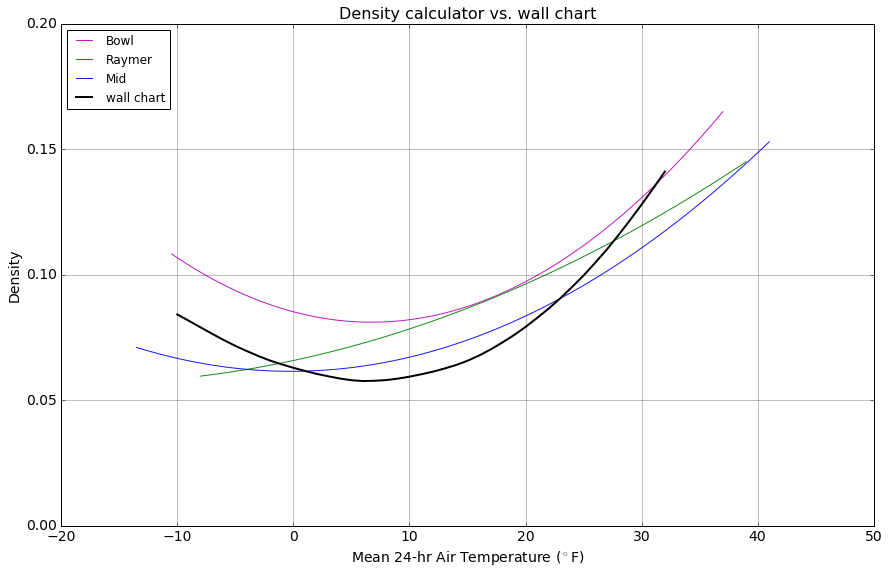

In [92]:
#-----------------------------------------------------------------------------
# TEMP VS. DENSITY: ADD WALL PLOT & CROCUS EQTN
#-----------------------------------------------------------------------------

# Define directory path:
fpath_wall='wall_chart.csv' # manual picks from wall chart photocopy

# Read in data:
walldata = pd.read_csv(fpath_wall, sep=',')
#walldata.Temp = (walldata.Temp - 32.) * (5./9.)

from scipy.signal import savgol_filter

#walldata_smooth = pd.rolling_mean(walldata, 2)
walldata_smooth = savgol_filter(walldata.Dens, 9, 3)

#-----------------------------------------------------------------------------
plt.figure(figsize=(9 * 1.618, 9))
#plt.plot(x, y, 'o', color='b', alpha=0.2)
plt.xlabel('Mean 24-hr Air Temperature ($^\circ$F)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Density calculator vs. wall chart', fontsize=16)
plt.xlim((-20, 50))
#plt.xlim((-30, 10))
plt.ylim((0, 0.20))
plt.grid(which='major', color='k', alpha=0.5, linestyle='-')

#-----------------------------------------------------------------------------
# BOWL

x = temp_mean_Summit_new[idx_bowl_new.index]
# Toggle below for metrics!
#x = (x - 32.) * (5./9.)

y = densityBowl_new[idx_bowl_new.index]

d = {'temp': x, 'dens': y}
df = pd.DataFrame(data=d)

# points linearly spaced for predictor variable
x1 = pd.DataFrame({'temp': np.linspace(df.temp.min(), df.temp.max(), 100)})

# 2nd order polynomial
poly_2 = smf.ols(formula='dens ~ 1 + temp + I(temp ** 2.0)', data=df).fit()
#poly_2 = smf.ols(formula='dens ~ 1 + wind', data=df).fit()  # 1st order
plt.plot(x1, poly_2.predict(x1), 'm-', label='Bowl', alpha=0.9)

#-----------------------------------------------------------------------------
# RAYMER

x = temp_mean_ray_new[idx_bridger_new.index]
# Toggle below for metrics!
#x = (x - 32.) * (5./9.)

y = densityBridger_new[idx_bridger_new.index]

d = {'temp': x, 'dens': y}
df = pd.DataFrame(data=d)

# points linearly spaced for predictor variable
x1 = pd.DataFrame({'temp': np.linspace(df.temp.min(), df.temp.max(), 100)})

# 2nd order polynomial
poly_2 = smf.ols(formula='dens ~ 1 + temp + I(temp ** 2.0)', data=df).fit()
#poly_2 = smf.ols(formula='dens ~ 1 + wind', data=df).fit()  # 1st order
plt.plot(x1, poly_2.predict(x1), 'g-', label='Raymer', alpha=0.9)

#-----------------------------------------------------------------------------
# MID

x = temp_mean_mid_new[idx_mid_new.index]
#x = (x - 32.) * (5./9.)

y = densityMid_new[idx_mid_new.index]

d = {'temp': x, 'dens': y}
df = pd.DataFrame(data=d)

# points linearly spaced for predictor variable
x1 = pd.DataFrame({'temp': np.linspace(df.temp.min(), df.temp.max(), 100)})

# 2nd order polynomial
poly_2 = smf.ols(formula='dens ~ 1 + temp + I(temp ** 2.0)', data=df).fit()
#poly_2 = smf.ols(formula='dens ~ 1 + wind', data=df).fit()  # 1st order
plt.plot(x1, poly_2.predict(x1), 'b-', label='Mid', alpha=0.9)

#-----------------------------------------------------------------------------
# WALL CHART

plt.plot(walldata.Temp, walldata_smooth, 'k-', linewidth=2, label='wall chart')
#plt.plot(walldata.Temp, walldata.Dens, 'r-', label='wall chart')  

plt.legend(loc=2)

#plt.savefig('wallchart_compare.png',dpi=350)

#plt.show()
#embed()    
